In [1]:
import os
import sys
import yaml
import math
import itertools

module_path = os.path.abspath(os.path.join('../../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from collections import defaultdict

from bson.objectid import ObjectId
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl

from src.utils.sacred_retrieval import SacredExperimentAccess, get_dicts_key_subset, get_unique_dicts, flatten_dict
from experiments.dispatch.dispatch_utils import nested_dict_to_option_strings

# plotting
# %config InlineBackend.figure_formats = ['svg']
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

In [2]:
with open('../../experiment_configs/adaptive_clipping/fixed.yaml', 'r') as f:
    experiment_config = yaml.load(f, Loader=yaml.FullLoader)
    
experiment_config = flatten_dict(experiment_config)
database = experiment_config["database"]

remove_list = []
for k, v in experiment_config.items():
    if isinstance(v, list):
        if len(v) == 1:
            remove_list.append(k)
        else:
            continue
    else:
        remove_list.append(k)
        
for k in remove_list: experiment_config.pop(k)

print(experiment_config)

all_options = nested_dict_to_option_strings(experiment_config)
product = itertools.product(*all_options)
dp_configs = [dict(item) for item in product]

results_access = SacredExperimentAccess(database_name=database)
adult_configs = dp_configs
adult_grid_experiments = [results_access.get_experiments(name='jalko2017_datapoint_exp', complete=True, config=config) for config in adult_configs]

adult_grid_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in adult_grid_experiments]
adult_eps_metrics = [results_access.get_metrics_by_exp(experiments, "epsilon", "in") for experiments in adult_grid_experiments]

{'privacy_settings.C': [25, 75, 125]}


In [3]:
with open('../../experiment_configs/adaptive_clipping/percentile_updated.yaml', 'r') as f:
    experiment_config_p = yaml.load(f, Loader=yaml.FullLoader)
    
experiment_config_p = flatten_dict(experiment_config_p)
database = experiment_config_p["database"]

remove_list = []
for k, v in experiment_config_p.items():
    if isinstance(v, list):
        if len(v) == 1:
            remove_list.append(k)
        else:
            continue
    else:
        remove_list.append(k)
        
for k in remove_list: experiment_config_p.pop(k)
experiment_config_p["experiment_tag"] = "datapoint_percentile_clipping_experiment_updated"

print(experiment_config_p)

all_options = nested_dict_to_option_strings(experiment_config_p)
product = itertools.product(*all_options)
dp_configs = [dict(item) for item in product]

results_access = SacredExperimentAccess(database_name=database)
adult_configs_p = dp_configs
adult_grid_experiments_p = [results_access.get_experiments(name='jalko2017_percentile_clip_datapoint_exp', complete=True, config=config) for config in adult_configs_p]

adult_grid_metrics_p = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in adult_grid_experiments_p]
adult_eps_metrics_p = [results_access.get_metrics_by_exp(experiments, "epsilon", "in") for experiments in adult_grid_experiments_p]

{'privacy_settings.C_percentile': [50, 75, 95], 'experiment_tag': 'datapoint_percentile_clipping_experiment_updated'}


50
75
95


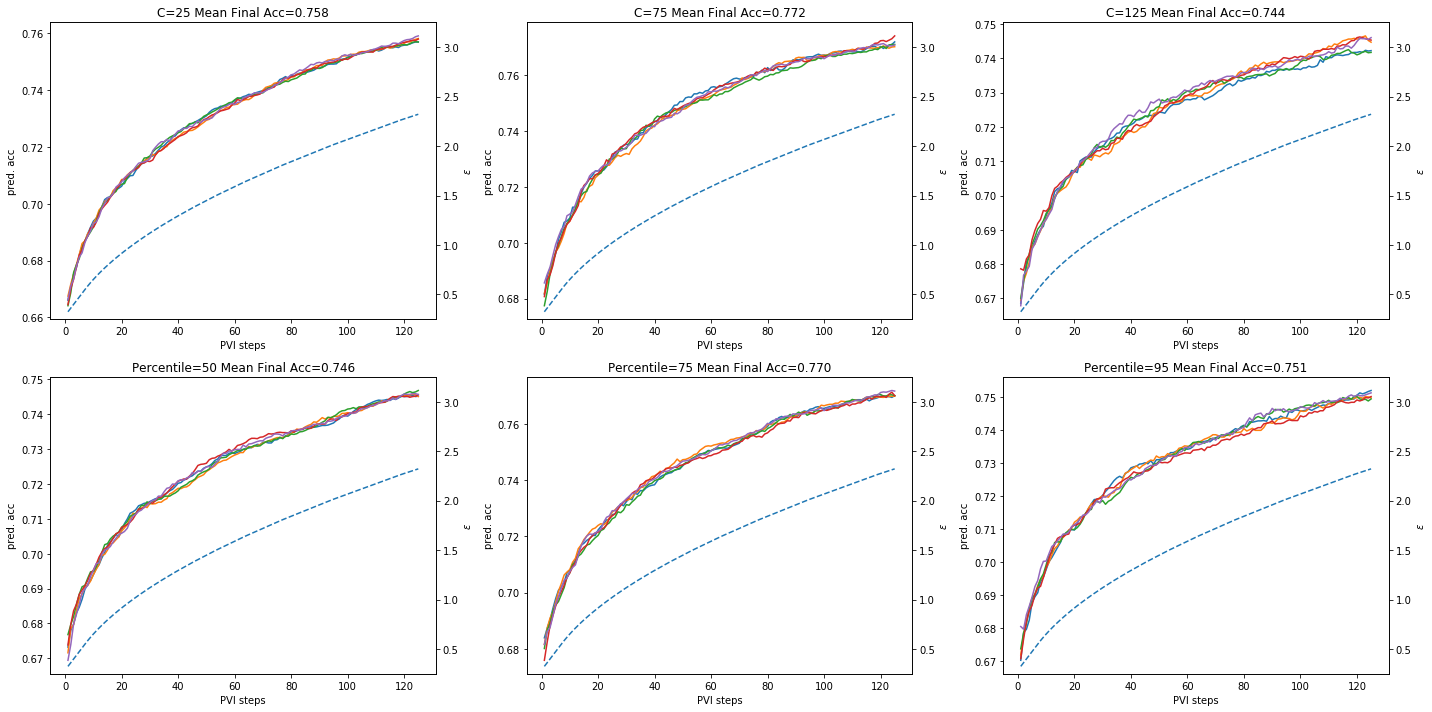

In [4]:
plt.figure(figsize=(20,10))
C_fixed = experiment_config["privacy_settings.C"]
C_percentile = experiment_config_p["privacy_settings.C_percentile"]
rows = len(C_fixed) + len(C_percentile)
cols=1

rows = 2
cols = 3

for config, experiments, metrics, eps_metrics in zip(adult_configs, adult_grid_experiments, adult_grid_metrics, adult_eps_metrics):
    C = config['privacy_settings.C']
    
    C_index = C_fixed.index(C)
    
    plot_ind = C_index + 1
    axes = plt.subplot(rows, cols, C_index + 1)
    
    if len(metrics) == 0: continue
    values = []
    for metric in metrics:
        values.append(metric[0]['values'])
    values = np.array(values).T
    steps = np.atleast_2d(np.array(metrics[0][0]['steps'])).T
    
    seed_eps_values = []
    for seed_indx, seed_eps in enumerate(eps_metrics):
        eps_values = []
        for client_eps in seed_eps:
            eps_values.append(np.array(client_eps["values"]).flatten())
        eps_values = np.array(eps_values)
        seed_eps_values.append(np.mean(eps_values, 0))
    
    final_mean_eps_values = np.mean(seed_eps_values, 0)
    
    axes2 = axes.twinx()
    
    plt.title(f"C={C} Mean Final Acc={np.mean(values[-1]):.3f}")
    
    axes2.plot(steps, final_mean_eps_values, '--')
    axes.plot(steps, values)
    axes.set_xlabel('PVI steps')
    axes.set_ylabel('pred. acc')
    axes2.set_ylabel('$\epsilon$')
    axes2.set_ylim(0.25, 3.25)
    
for config, experiments, metrics, eps_metrics in zip(adult_configs_p, adult_grid_experiments_p, adult_grid_metrics_p, adult_eps_metrics_p):
    C_p = config['privacy_settings.C_percentile']
    print(C_p)
    
    C_index = C_percentile.index(C_p)
    axes = plt.subplot(rows, cols, C_index + 1 + len(C_fixed))
    
    if len(metrics) == 0: continue
    values = []
    for metric in metrics:
        values.append(metric[0]['values'])
    values = np.array(values).T
    steps = np.atleast_2d(np.array(metrics[0][0]['steps'])).T
    
    seed_eps_values = []
    for seed_indx, seed_eps in enumerate(eps_metrics):
        eps_values = []
        for client_eps in seed_eps:
            eps_values.append(np.array(client_eps["values"]).flatten())
        eps_values = np.array(eps_values)
        seed_eps_values.append(np.mean(eps_values, 0))
    
    final_mean_eps_values = np.mean(seed_eps_values, 0)
    
    axes2 = axes.twinx()
    
    plt.title(f"Percentile={C_p} Mean Final Acc={np.mean(values[-1]):.3f}")
    
    axes2.plot(steps, final_mean_eps_values, '--')
    axes.plot(steps, values)
    axes.set_xlabel('PVI steps')
    axes.set_ylabel('pred. acc')
    axes2.set_ylabel('$\epsilon$')
    axes2.set_ylim(0.25, 3.25)
    
    
plt.tight_layout()

Looking at this, it doesn't seem that an adaptive clipping bound performs that much better, or at all better than a changing one, but perhaps the adaptive clipping bound means that we can get away with less damping? The current damping factor above is $\alpha = 0.2$. 

In [17]:
with open('../../experiment_configs/adaptive_clipping/fixed_less_damping.yaml', 'r') as f:
    experiment_config = yaml.load(f, Loader=yaml.FullLoader)
    
experiment_config = flatten_dict(experiment_config)
database = experiment_config["database"]

remove_list = []
for k, v in experiment_config.items():
    if isinstance(v, list):
        if len(v) == 1:
            remove_list.append(k)
        else:
            continue
    else:
        remove_list.append(k)
        
for k in remove_list: experiment_config.pop(k)

experiment_config["experiment_tag"] = "datapoint_experiment_fixed_less_damping"
print(experiment_config)

all_options = nested_dict_to_option_strings(experiment_config)
product = itertools.product(*all_options)
dp_configs = [dict(item) for item in product]

results_access = SacredExperimentAccess(database_name=database)
adult_configs = dp_configs
adult_grid_experiments = [results_access.get_experiments(name='jalko2017_datapoint_exp', complete=False, config=config, additional_filter={"status": "PROBABLY_DEAD"}) for config in adult_configs]

adult_grid_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy"]) for experiments in adult_grid_experiments]
adult_eps_metrics = [results_access.get_metrics_by_exp(experiments, "epsilon", "in") for experiments in adult_grid_experiments]

with open('../../experiment_configs/adaptive_clipping/percentile_updated_less_damping.yaml', 'r') as f:
    experiment_config_p = yaml.load(f, Loader=yaml.FullLoader)
    
experiment_config_p = flatten_dict(experiment_config_p)
database = experiment_config_p["database"]

remove_list = []
for k, v in experiment_config_p.items():
    if isinstance(v, list):
        if len(v) == 1:
            remove_list.append(k)
        else:
            continue
    else:
        remove_list.append(k)
        
for k in remove_list: experiment_config_p.pop(k)
experiment_config_p["experiment_tag"] = "datapoint_percentile_clipping_experiment_updated_less_damping"

print(experiment_config_p)

all_options = nested_dict_to_option_strings(experiment_config_p)
product = itertools.product(*all_options)
dp_configs = [dict(item) for item in product]

results_access = SacredExperimentAccess(database_name=database)
adult_configs_p = dp_configs
adult_grid_experiments_p = [results_access.get_experiments(name='jalko2017_percentile_clip_datapoint_exp', complete=False, config=config, additional_filter={"status": "COMPLETED"}) for config in adult_configs_p]

adult_grid_metrics_p = [results_access.get_metrics_by_exp(experiments, ["test_accuracy"]) for experiments in adult_grid_experiments_p]
adult_eps_metrics_p = [results_access.get_metrics_by_exp(experiments, "epsilon", "in") for experiments in adult_grid_experiments_p]

{'privacy_settings.C': [25, 75, 125], 'PVI_settings.damping_factor': [0.8, 0.5, 0.3], 'experiment_tag': 'datapoint_experiment_fixed_less_damping'}
{'privacy_settings.C_percentile': [50, 75, 95], 'PVI_settings.damping_factor': [0.8, 0.5, 0.3], 'experiment_tag': 'datapoint_percentile_clipping_experiment_updated_less_damping'}


/Users/msharma/.local/share/virtualenvs/DP-PVI-jh1H6qk4/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


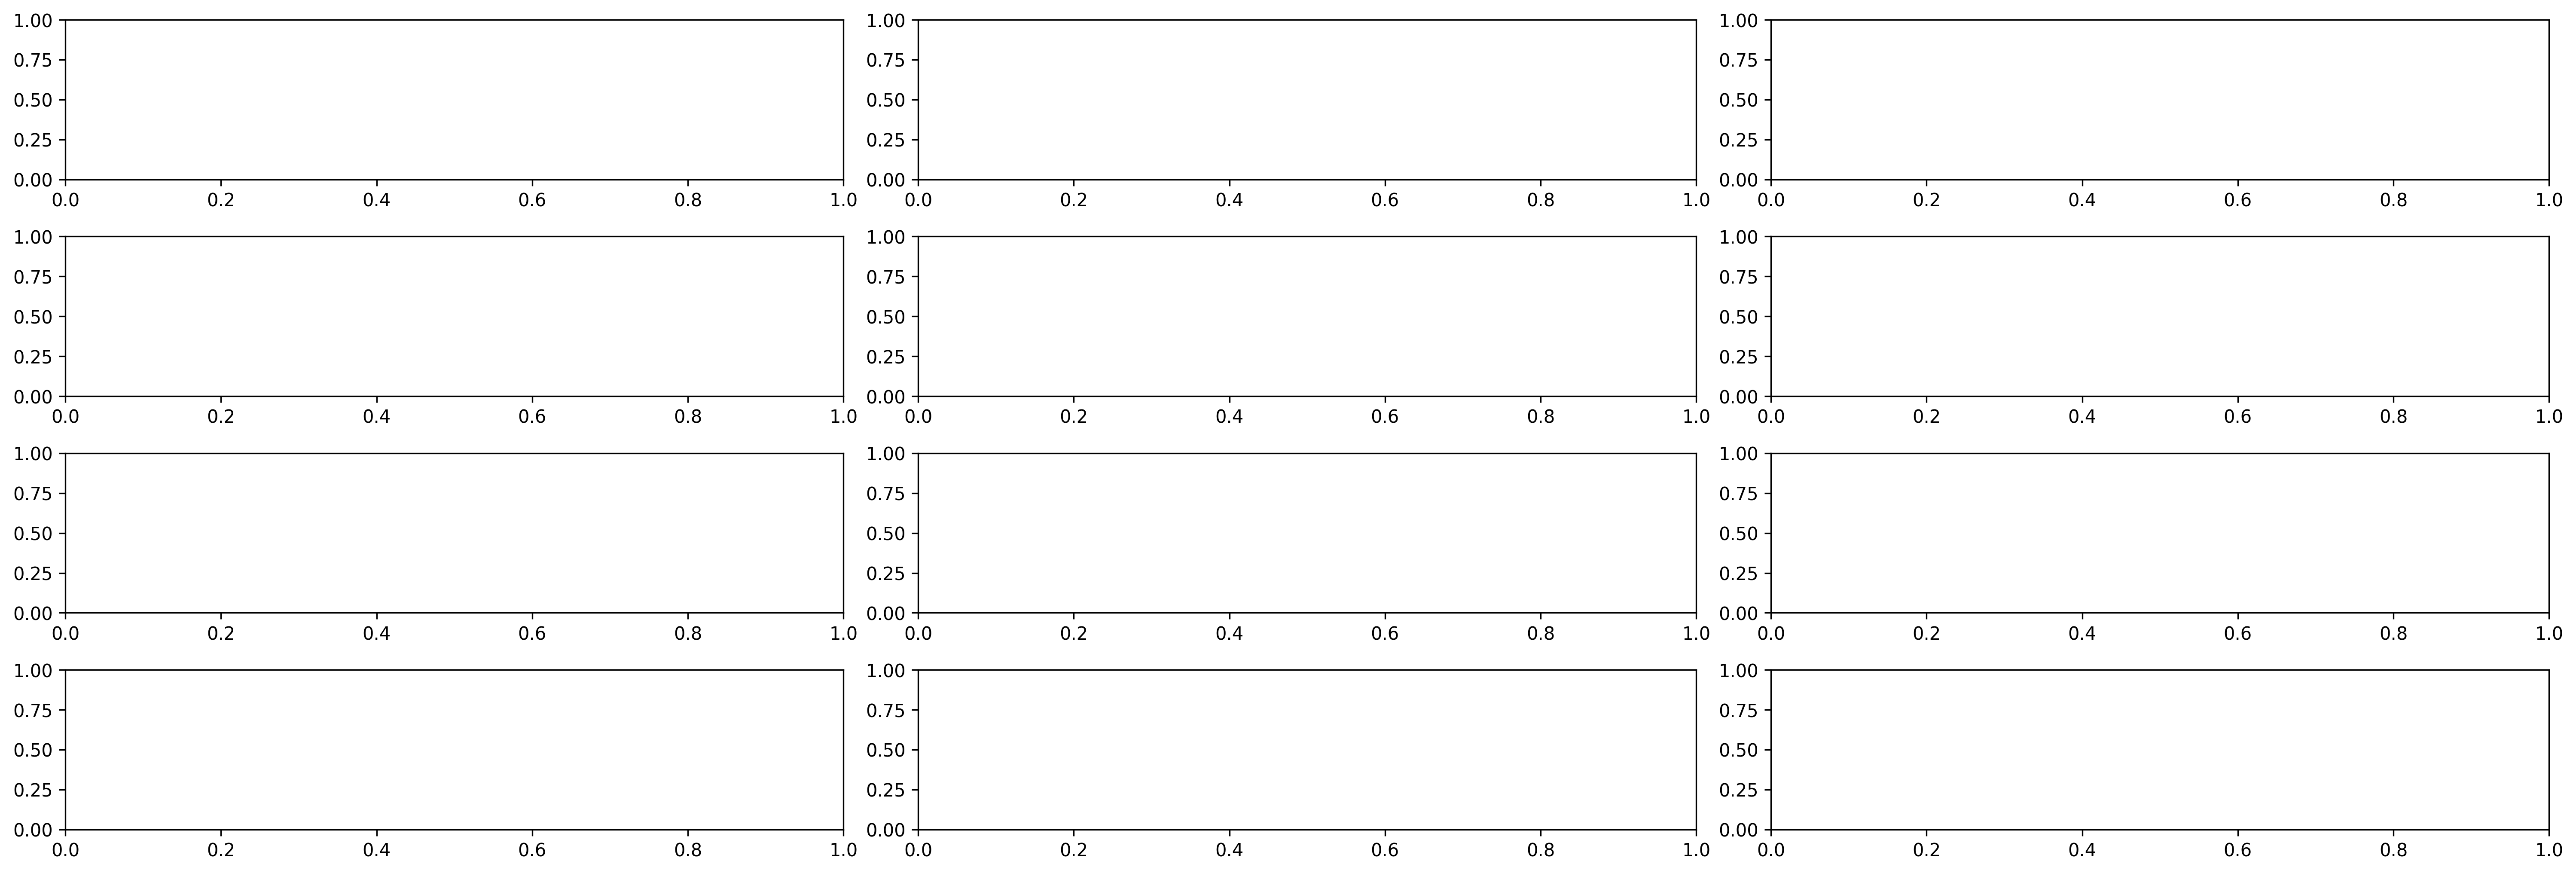

In [98]:
plt.figure(figsize=(20,10))
C_fixed = experiment_config["privacy_settings.C"]
C_percentile = experiment_config_p["privacy_settings.C_percentile"]
damping_factors = experiment_config_p["PVI_settings.damping_factor"]
rows = len(C_fixed) + len(C_percentile)
cols= len(damping_factors)


for config, experiments, metrics, eps_metrics in zip(adult_configs, adult_grid_experiments, adult_grid_metrics, adult_eps_metrics):
    C = config['privacy_settings.C'] 
    C_index = C_fixed.index(C)
    damping = config['PVI_settings.damping_factor']
    damping_index = damping_factors.index(damping)
    
    plot_ind = C_index + 1
    axes = plt.subplot(rows, cols, damping_index * cols + C_index + 1)
    
    if len(metrics) == 0: continue
    values = []
    for metric in metrics:
        values.append(metric[0]['values'])
    values = np.array(values).T
    steps = np.atleast_2d(np.array(metrics[0][0]['steps'])).T
    
    seed_eps_values = []
    for seed_indx, seed_eps in enumerate(eps_metrics):
        eps_values = []
        for client_eps in seed_eps:
            eps_values.append(np.array(client_eps["values"]).flatten())
        eps_values = np.array(eps_values)
        seed_eps_values.append(np.mean(eps_values, 0))
    
    final_mean_eps_values = np.mean(seed_eps_values, 0)
    
    axes2 = axes.twinx()
    
    plt.title(f"C={C} $\\alpha={damping}$ Mean Final Acc={np.mean(values[-1]):.3f}")
    
    axes2.plot(steps, final_mean_eps_values, '--')
    axes.plot(steps, values)
    axes.set_xlabel('PVI steps')
    axes.set_ylabel('pred. acc')
    axes2.set_ylabel('$\epsilon$')
    axes2.set_ylim(0.25, 3.25)
    
for config, experiments, metrics, eps_metrics in zip(adult_configs_p, adult_grid_experiments_p, adult_grid_metrics_p, adult_eps_metrics_p):
    C_p = config['privacy_settings.C_percentile']
    
    C_index = C_percentile.index(C_p)
    
    damping = config['PVI_settings.damping_factor']
    damping_index = damping_factors.index(damping)
    
    plot_ind = C_index + 1
    axes = plt.subplot(rows, cols, damping_index * cols + C_index + 1 + len(C_fixed))
    
    if len(metrics) == 0: continue
    values = []
    for metric in metrics:
        values.append(metric[0]['values'])
    values = np.array(values).T
    steps = np.atleast_2d(np.array(metrics[0][0]['steps'])).T
    
    seed_eps_values = []
    for seed_indx, seed_eps in enumerate(eps_metrics):
        eps_values = []
        for client_eps in seed_eps:
            eps_values.append(np.array(client_eps["values"]).flatten())
        eps_values = np.array(eps_values)
        seed_eps_values.append(np.mean(eps_values, 0))
    
    final_mean_eps_values = np.mean(seed_eps_values, 0)
    
    axes2 = axes.twinx()
    
    plt.title(f"Percentile={C_p} $\\alpha={damping}$ Mean Final Acc={np.mean(values[-1]):.3f}")
    
    axes2.plot(steps, final_mean_eps_values, '--')
    axes.plot(steps, values)
    axes.set_xlabel('PVI steps')
    axes.set_ylabel('pred. acc')
    axes2.set_ylabel('$\epsilon$')
    axes2.set_ylim(0.25, 3.25)
    
    
plt.tight_layout()

In [19]:
adult_grid_experiments

[[], [], [], [], [], [], [], [], []]

In [49]:
results_access = SacredExperimentAccess(database_name="adaptive_clipping")
results_access.get_experiments()[0]

{'_id': 44,
 'experiment': {'name': 'jalko2017_percentile_clip_datapoint_exp',
  'base_dir': '/scratch/DP-PVI/DP-PVI/experiments/jalko2017',
  'sources': [['MongoDBOption.py', ObjectId('5d6a4052e9a20fb0f0a6a806')],
   ['__init__.py', ObjectId('5d6a4052e9a20fb0f0a6a808')],
   ['datapoint_percentile_clipping_experiment.py',
    ObjectId('5d6d106e0ac8995e1ebe06ec')],
   ['ingredients/__init__.py', ObjectId('5d6a4052e9a20fb0f0a6a80b')],
   ['ingredients/data_distribution.py', ObjectId('5d6a4052e9a20fb0f0a6a80c')],
   ['ingredients/dataset_ingredient.py', ObjectId('5d6a4052e9a20fb0f0a6a80e')],
   ['measure_performance.py', ObjectId('5d6a4052e9a20fb0f0a6a810')]],
  'dependencies': ['numpy==1.17.0',
   'pyarrow==0.14.1',
   'ray==0.7.3',
   'sacred==0.7.5',
   'torch==1.1.0'],
  'repositories': [{'url': 'https://github.com/MrinankSharma/DP-PVI.git',
    'commit': 'aac16384f513bc816d112e52316e7062667baacc',
    'dirty': False},
   {'url': 'https://github.com/MrinankSharma/DP-PVI.git',
    'com

[{'privacy_settings.C_percentile': 50,
  'PVI_settings.damping_factor': 0.8,
  'experiment_tag': 'datapoint_percentile_clipping_experiment_updated_less_damping'},
 {'privacy_settings.C_percentile': 50,
  'PVI_settings.damping_factor': 0.5,
  'experiment_tag': 'datapoint_percentile_clipping_experiment_updated_less_damping'},
 {'privacy_settings.C_percentile': 50,
  'PVI_settings.damping_factor': 0.3,
  'experiment_tag': 'datapoint_percentile_clipping_experiment_updated_less_damping'},
 {'privacy_settings.C_percentile': 75,
  'PVI_settings.damping_factor': 0.8,
  'experiment_tag': 'datapoint_percentile_clipping_experiment_updated_less_damping'},
 {'privacy_settings.C_percentile': 75,
  'PVI_settings.damping_factor': 0.5,
  'experiment_tag': 'datapoint_percentile_clipping_experiment_updated_less_damping'},
 {'privacy_settings.C_percentile': 75,
  'PVI_settings.damping_factor': 0.3,
  'experiment_tag': 'datapoint_percentile_clipping_experiment_updated_less_damping'},
 {'privacy_settings.C_